In [0]:
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import csv
import matplotlib.pyplot as plt
import numpy as np
import os

## Downloading the dataset

In [0]:
if not os.path.exists('colors.csv'):
  !curl -O 'https://raw.githubusercontent.com/random-forests/datasets/master/colors.csv'
!head colors.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  323k  100  323k    0     0   839k      0 --:--:-- --:--:-- --:--:--  836k
name,red,green,blue
parakeet,174,182,87
saddle brown,88,52,1
cucumber crush,222,237,215
pool blue,134,194,201
distance,98,110,130
light urple,179,111,246
east side,172,145,206
florida seashells,250,228,199
paris,145,167,189


## Reading the data

In [0]:

colors_rgb = []
csv_reader = csv.reader(open('colors.csv'), delimiter=',')
next(csv_reader) # Remove the header
for row in csv_reader:
    name, r, g, b = row[0].lower().strip(), float(row[1]) / 255.0, float(row[2]) / 255.0, float(row[3]) / 255.0
    colors_rgb.append((name, r, g, b))
print(len(colors_rgb), 'colors downloaded')
print('For example', colors_rgb[0])

14157 colors downloaded
For example ('parakeet', 0.6823529411764706, 0.7137254901960784, 0.3411764705882353)


In [0]:
names = [item[0] for item in colors_rgb]

In [0]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = pad_sequences(tokenized, maxlen=maxlen)
padded_names = padded_names.astype('float32')

In [0]:
r = [item[1] for item in colors_rgb]
g = [item[2] for item in colors_rgb]
b = [item[3] for item in colors_rgb]
targets = np.column_stack([r, g, b])

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((1, maxlen), input_shape=(maxlen,)))
model.add(tf.keras.layers.GRU(128,return_sequences=True))
model.add(tf.keras.layers.GRU(128))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model.compile(optimizer=tf.train.AdamOptimizer(), loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 25)             0         
_________________________________________________________________
gru (GRU)                    (None, 1, 128)            59136     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 166,275
Trainable params: 166,275
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(padded_names, targets, epochs=35, validation_split=0.1)

Train on 12741 samples, validate on 1416 samples


W0701 17:17:18.351777 140685905508224 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/35
12741/12741 [==============================] - 9s 721us/sample - loss: 0.0626 - val_loss: 0.0629
Epoch 2/35
12741/12741 [==============================] - 5s 382us/sample - loss: 0.0593 - val_loss: 0.0621
Epoch 3/35
12741/12741 [==============================] - 5s 378us/sample - loss: 0.0575 - val_loss: 0.0610
Epoch 4/35
12741/12741 [==============================] - 5s 377us/sample - loss: 0.0559 - val_loss: 0.0607
Epoch 5/35
12741/12741 [==============================] - 5s 376us/sample - loss: 0.0544 - val_loss: 0.0597
Epoch 6/35
12741/12741 [==============================] - 5s 381us/sample - loss: 0.0527 - val_loss: 0.0595
Epoch 7/35
12741/12741 [==============================] - 5s 385us/sample - loss: 0.0515 - val_loss: 0.0595
Epoch 8/35
12741/12741 [==============================] - 5s 372us/sample - loss: 0.0496 - val_loss: 0.0595
Epoch 9/35
12741/12741 [==============================] - 5s 378us/sample - loss: 0.0483 - val_loss: 0.0595
Epoch 10/35
12741/12741 [===

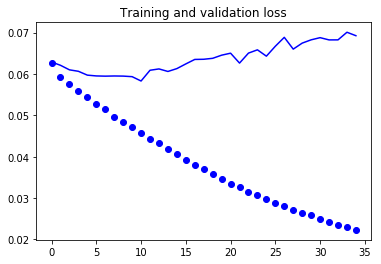

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.show()

## Overfitted the data massively.. Let's now see the result!

In [0]:
# plots a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [0]:
def scale(n):
    return int(n * 255)

In [0]:
def predict(name):
    tokenized = t.texts_to_sequences([name])
    padded = pad_sequences(tokenized, maxlen=maxlen)
    padded = padded.astype('float32')
    pred = model.predict(np.array(padded))[0]
    # Check the shapes here if you run into trouble with the next 
    # method after adding your RNN
    print(pred)
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

[0.42921725 0.5714721  0.66559905]
light blue, R,G,B: 109 145 169


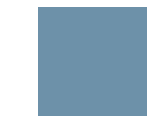

[0.09268745 0.10647664 0.10703159]
black, R,G,B: 23 27 27


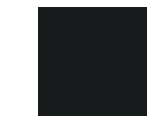

[0.09794722 0.22268204 0.5145395 ]
dark blue, R,G,B: 24 56 131


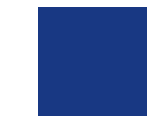

In [0]:
# some "test" data
predict("light blue")
predict("black")
predict("dark blue")